# Arrhythmia

This example demonstrates how to use the `RhythmData` class provided in the `pyheartlib` to create a dataset for arrhythmia classification. The dataset will contain signals and annotations, as well as metadata about the excerpts. The metadata for each excerpt includes the record ID, the onset and offset of the excerpt on the raw signal, and the annotation. Finally, the `ECGSequence` class will be used to generate batches of sample data from the information available in the dataset.

This example is available on [GitHub](https://github.com/devnums/pyheartlib/blob/main/examples/).

<a target="_blank" href="https://colab.research.google.com/github/devnums/pyheartlib/blob/main/examples/dataset/arrhythmia.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 

## Install pyheartlib

First, `pyheartlib` needs to be installed.

In [1]:
try:
    import pyheartlib
    print('pyheartlib is already installed')
except ModuleNotFoundError:
    print('Installing pyheartlib...')
    %pip install pyheartlib

pyheartlib is already installed


## Download raw data

`Pyheartlib` supports the WFDB format. A popular dataset that uses this format is the "MIT-BIH Arrhythmia Database". The code below downloads this dataset and stores it in the data directory.

In [2]:
# Download the raw data and store them in the base data directory
from pathlib import Path
if not Path('data').is_dir():
  print('downloading raw data...')
  import io, zipfile
  from urllib.request import urlopen
  url='https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip'
  with urlopen(url) as rs:
      zipf = zipfile.ZipFile(io.BytesIO(rs.read()))
      zipf.extractall('data/')

  # Create the config file. For this example, it will be download from the original repository
  with urlopen("https://raw.githubusercontent.com/devnums/pyheartlib/main/src/pyheartlib/config.yaml") as file:
      content = file.read().decode()
  with open("data/config.yaml", 'w') as file:
      file.write(content)

## Create dataset

To create a dataset for arrhythmia classification, the `RhythmData` class must be used. This class can be imported using the code below.
```python
from pyheartlib.data_rhythm import RhythmData
```

The next step is to create an object of the `pyheartlib.data_rhythm.RhythmData`. 

```python
rhythm_data = RhythmData(
    base_path="data", remove_bl=False, lowpass=False, progress_bar=False
)
```

Descriptions of all the parameters can be found [here](../../introduction.html#directive-rdt).

Using the `save_samples()` method, the dataset will be created.

```python
rhythm_data.save_samples(
    rec_list=train_set, file_name="train.arr", win_size=3600, stride=64
)
```

Let's create the dataset by running the next code block.

In [3]:
import numpy as np
import pandas as pd
from pyheartlib.data_rhythm import RhythmData

# Make an instance of the RhythmData
rhythm_data = RhythmData(
    base_path="data", remove_bl=False, lowpass=False, progress_bar=False
)

# Define records
train_set = [201, 203]

# Create the dataset
rhythm_data.save_samples(
    rec_list=train_set, file_name="train.arr", win_size=3600, stride=64
)


File saved at: data/train.arr


Now that the dataset is ready, it can be loaded using the `load_data()` function.
```python
from pyheartlib.io import load_data
annotated_records, samples_info = load_data("data/train.arr")
```

Let's load the data and count the number of samples for each arrhythmia class.

In [4]:
# Load the dataset
from pyheartlib.io import load_data
annotated_records, samples_info = load_data("data/train.arr")

labels = []
for sample in samples_info:
    labels.append(sample[3])
class_labels = list(np.unique(labels))
df = pd.DataFrame(np.unique(labels, return_counts=True), index=["Label", "Count"])
print(df)

File loaded from: data/train.arr
           0     1     2     3
Label  (AFIB  (AFL    (N    (T
Count  10330  1656  3594  1584


The metadata of a sample is a list: [record ID, onset, offset, annotation]

In [5]:
# Metadata of a sample excerpt
# [record ID, onset, offset, annotation]
print(samples_info[265])

[0, 17024, 20624, '(AFIB']


## Generate data samples

In this section, the dataset that was created in the previous section will be used to generate batches of sample data. To accomplish this, an instance of `pyheartlib.data_rhythm.ECGSequence` must be created.
```python
from pyheartlib.data_rhythm import ECGSequence

trainseq = ECGSequence(
    annotated_records,
    samples_info,
    class_labels=None,
    batch_size=3,
    raw=True,
    interval=36,
    shuffle=False,
    rri_length=20
)
```

The `ECGSequence` takes the  *annotated_records* (ECG records) and the *samples_info* (metadata) that were loaded previously.

Other parameters that `ECGSequence` takes can be found [here](../../introduction.html#directive-rsq).

Let's generate a batch of data and examine the shapes and values of the samples.

In [6]:
# Generate data in batch using he ECGSequence

# If raw is False, the waveform part of the output has the shape of (batch_size, #sub-segments, #features),
# otherwise, it has the shape of (batch_size, excerpt_length)
from pyheartlib.data_rhythm import ECGSequence

trainseq = ECGSequence(
    annotated_records,
    samples_info,
    class_labels=None,
    batch_size=3,
    raw=True,
    interval=36,
    shuffle=False,
    rri_length=25
)
bt = 0  # Batch number
batch_annotation = trainseq[bt][1]  # Annotation
batch_wave = trainseq[bt][0][0]  # Excerpt values
batch_rri = trainseq[bt][0][1]  # RR-intervals
batch_rri_feat = trainseq[bt][0][2]  # Computed RR-interval features
print("batch_annotation shape:", batch_annotation.shape)
print(
    "batch_wave shape:",
    batch_wave.shape,
    " , batch_rri shape:",
    batch_rri.shape,
    " , batch_rri_feat shape:",
    batch_rri_feat.shape,
)
print("Length of each sample excerpt:", len(batch_wave[0]))

batch_annotation shape: (3,)
batch_wave shape: (3, 3600)  , batch_rri shape: (3, 25)  , batch_rri_feat shape: (3, 9)
Length of each sample excerpt: 3600


In [7]:
# Annotations of the samples in the batch
print(batch_annotation)

['(AFIB' '(AFIB' '(AFIB']


Length of each sample excerpt: 3600


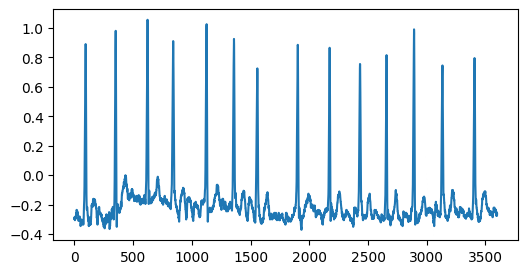

In [8]:
# Plot an output excerpt of the batch
print("Length of each sample excerpt:", len(batch_wave[0]))
wf = batch_wave[0]
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 3))
plt.plot(wf);

In [9]:
# RR-intervals availble in a sample, the list is zero-padded on the right side
print(batch_rri[0])

[0.71111111 0.75277778 0.60833333 0.78888889 0.64722222 0.55277778
 0.95555556 0.75277778 0.71944444 0.62777778 0.65       0.67222222
 0.75833333 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


The code below generates a batch with the `raw` parameter set to *False*. In this case, the generated batch contains computed features instead of raw waveform.

In [10]:
# When raw is set to False
trainseq = ECGSequence(
    annotated_records,
    samples_info,
    class_labels=None,
    batch_size=3,
    raw=False,
    interval=36,
)
bt = 0  # Batch number
batch_annotation = trainseq[bt][1]  # Excerpt label
batch_wave = trainseq[bt][0][0]  # Excerpt values
batch_rri = trainseq[bt][0][1]  # RR-intervals
batch_rri_feat = trainseq[bt][0][2]  # Computed RR-interval features
print("batch_annotation shape:", batch_annotation.shape)
print(
    "batch_wave shape:",
    batch_wave.shape,
    " , batch_rri shape:",
    batch_rri.shape,
    " , batch_rri_feat shape:",
    batch_rri_feat.shape,
)

batch_annotation shape: (3,)
batch_wave shape: (3, 100, 14)  , batch_rri shape: (3, 150)  , batch_rri_feat shape: (3, 9)
